## Hierarchical Classification NLP task
### by Christian Grech

## 1. Import packages and data

In [10]:
import json
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
pd.set_option('display.max_rows', 800)

In [11]:
import os

# Define the file paths
data_file = 'data.json'
test_data_file = 'test_data.json'

# Check if the files exist before attempting to read them
if not os.path.exists(data_file):
    print(f"Error: The file '{data_file}' was not found.")
elif not os.path.exists(test_data_file):
    print(f"Error: The file '{test_data_file}' was not found.")
else:
    # Import the two datasets
    df = pd.read_json(data_file)
    test_df = pd.read_json(test_data_file)
    print("Data files loaded successfully!")

Data files loaded successfully!


## 2. Feature extraction: defining hierarchy levels

In [12]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.json to data (2).json
Saving test_data.json to test_data (2).json
User uploaded file "data (2).json" with length 422442 bytes
User uploaded file "test_data (2).json" with length 28842 bytes


In [13]:
df['short_html'] = df['html'].str.slice(0, 25)# Slice the html code as we are only interested in the HTML tags

# Create a dictionary to store the hierarchical level for each paragraph
hierarchical_levels = {}

# Initialize the hierarchical level for the root paragraphs
for i, row in df.iterrows():
    if row['parent_id'] is None:
        hierarchical_levels[row['id']] = 0

# Recursively update the hierarchical level for child paragraphs (Source: Bard)
def update_hierarchical_levels(paragraph_id):
    if paragraph_id not in hierarchical_levels:
        parent_id = df[df['id'] == paragraph_id]['parent_id'].values[0]
        hierarchical_level = hierarchical_levels[parent_id] + 1
        hierarchical_levels[paragraph_id] = hierarchical_level
        update_hierarchical_levels(parent_id)

for i, row in df.iterrows():
    if row['parent_id'] is not None:
        update_hierarchical_levels(row['id'])

# Add the hierarchical level to the DataFrame
df['hierarchical_level'] = df['id'].apply(lambda id: hierarchical_levels[id])

df.head(10) # Show the first 10 entries

,id,parent_id,html,short_html,hierarchical_level
0,64da21ed3f42347f0fc701aa,None,<div><p><strong>&#167; 12.1 Cooperation with c...,<div><p><strong>&#167; 12,0
1,64da21ed3f42347f0fc701ab,64da21ed3f42347f0fc701aa,"<p>(a) <em>Federal Food, Drug, and Cosmetic Ac...","<p>(a) <em>Federal Food,",1
2,64da21ed3f42347f0fc701ac,64da21ed3f42347f0fc701aa,"<p>(b) <em>Federal Insecticide, Fungicide, and...",<p>(b) <em>Federal Insect,1
3,64da21ed3f42347f0fc701ad,64da21ed3f42347f0fc701aa,<p>(c) <em>Federal Hazardous Substances Act.</...,<p>(c) <em>Federal Hazard,1
4,64da21ed3f42347f0fc701ae,None,<div><p><strong>&#167; 12.3 Release under bond...,<div><p><strong>&#167; 12,0
5,64da21ed3f42347f0fc701af,64da21ed3f42347f0fc701ae,"<p>(a) <em>Release.</em> No food, drug, device...",<p>(a) <em>Release.</em>,1
6,64da21ed3f42347f0fc701b0,64da21ed3f42347f0fc701ae,<p>(b) <em>Bond amount.</em> The bond referred...,<p>(b) <em>Bond amount.</,1
7,64da21ed3f42347f0fc701b1,64da21ed3f42347f0fc701b0,<p>(1) Equal to the domestic value (see § 162....,<p>(1) Equal to the domes,2
8,64da21ed3f42347f0fc701b2,64da21ed3f42347f0fc701b0,<p>(2) Equal to three times the value of the m...,<p>(2) Equal to three tim,2
9,64da21ed3f42347f0fc701b3,64da21ed3f42347f0fc701ae,<p>(c) <em>Liquidated damages.</em> Whenever l...,<p>(c) <em>Liquidated dam,1


## 3. Testing the Vectorizer

Making sure that the vectorizer is able to detect HTML tags and converting these to numerical values. One example is taken here.

In [14]:
text = [(df['short_html'].tolist()[727])]
# create the transform
vectorizer = CountVectorizer(analyzer='word', lowercase=False, token_pattern=r'\W+[A-Za-z\d]*\W\d?')
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print('Extracted Vocabulary: ', vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print('Vector Shape: ', vector.shape)

Extracted Vocabulary:  {'<p>': 3, '(<em>3': 0, '</em>': 2, ') The ': 1}
Vector Shape:  (1, 4)


## 4. Training and testing various classifiers


Data is first transformed, split and various classifiers are tested. The XGBoost Classifier was found to be the best-performing and so a confusion matrix is plotted here with the results.

In [15]:

# Define a Column Transformer to vectorize all html text
column_trans = ColumnTransformer([
    ('tfidf', CountVectorizer(analyzer='word', lowercase=False, token_pattern=r'\W+[A-Za-z\d]*\W\d?'), 'short_html')
])

X = column_trans.fit_transform(df)
X_data = X.toarray()
y_data = df.loc[:, "hierarchical_level"].values

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state = 21, shuffle=True)



In [16]:
# Try several model examples to compare performance

names = [
    "Nearest Neighbors",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "XGBoost",
]

classifiers = [
    KNeighborsClassifier(10),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=8, random_state=42),
    RandomForestClassifier(max_depth=8, n_estimators=100, max_features=1, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,gamma=0,seed=27)
]


for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    #score = clf.score(X_val, y_val)
    y_pred = clf.predict(X_val)
    balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    print(name, '     Accuracy: ',  np.round(accuracy, 2), '     Balanced Accuracy: ', np.round(balanced_accuracy,2))

Nearest Neighbors      Accuracy:  0.9      Balanced Accuracy:  0.68
Gaussian Process      Accuracy:  0.93      Balanced Accuracy:  0.65
Decision Tree      Accuracy:  0.88      Balanced Accuracy:  0.61
Random Forest      Accuracy:  0.53      Balanced Accuracy:  0.29
Neural Net      Accuracy:  0.95      Balanced Accuracy:  0.72
AdaBoost      Accuracy:  0.68      Balanced Accuracy:  0.52
Naive Bayes      Accuracy:  0.85      Balanced Accuracy:  0.84
XGBoost      Accuracy:  0.96      Balanced Accuracy:  0.85


Accuracy: 0.9363057324840764


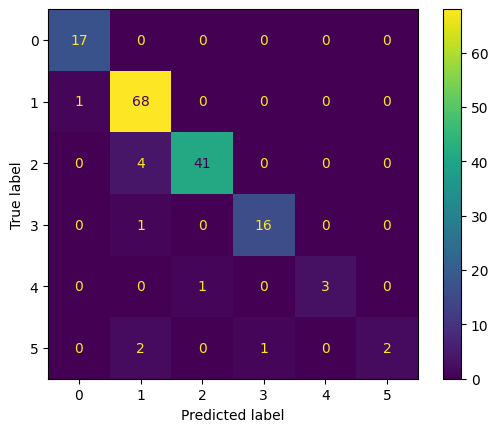

In [17]:
# The XGB model was chosen after the performance tests
model = XGBClassifier(
 learning_rate =0.02,n_estimators=100,max_depth=5, gamma=0,seed=27)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy:', accuracy)

cm = confusion_matrix(y_val, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

### 5. Training one model with the full training data

To ensure the best model, the XGBClassifier is trained with the whole training dataset, and then used with the test data.

In [18]:
test_df['short_html'] = test_df['html'].str.slice(0, 25)# Slice the html code as we are only interested in the HTML tags
# Add the hierarchical level to the DataFrame
X_test = column_trans.transform(test_df)
X_test_data = X_test.toarray()

In [19]:
test_model = XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,gamma=0,seed=27)
test_model.fit(X_data, y_data) # Fitting the model to the whole training dataset
y_pred = test_model.predict(X_test_data)


In [20]:
test_df['level'] = y_pred # Append predictions to the test dataframe
test_df.head(5) # Show a small example of the predictions

,id,html,short_html,level
0,64c5120bcce38659fc9e4bb1,<div><p><strong>&#167; 259.1 Purpose.</strong>...,<div><p><strong>&#167; 25,0
1,64c5120bcce38659fc9e4bb2,<p>The Guide in this part contains administrat...,<p>The Guide in this part,1
2,64c5120bcce38659fc9e4bb3,<div><p><strong>&#167; 259.2 Definitions.</str...,<div><p><strong>&#167; 25,0
3,64c5120bcce38659fc9e4bb4,"<p>For the purposes of this part, the followin...",<p>For the purposes of th,1
4,64c5120bcce38659fc9e4bb5,<p><em>Alternative fueled vehicle.</em> Any ve...,<p><em>Alternative fueled,2


### 6. Generate HTML file

In [21]:
# Generate HTML with indentations (indentations are defined as 4 times the level number)
def generate_html(node, level=0):
    html = f"<div style='margin-left:{level*4}em'>{node}</div>"
    return html

# Generate HTML for the entire test hierarchy
test_html = ""
for i, row in test_df.iterrows():
    test_html += generate_html(row['html'],int(row['level']))

# Save test.html
with open('test.html', 'w') as f:
    f.write(test_html)

### 7. Conclusion

Performance improvement suggestions:
* Improve regex pattern
* Finetune models

In [22]:
from google.colab import files

files.download('test.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>